<a href="https://colab.research.google.com/github/imanubhav/KARUNA_GO/blob/master/CDQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [0]:
!pip install --upgrade pandas

In [0]:
!pip3 install googletrans

In [0]:
!pip3 install cdqa

In [0]:
corpus=pd.read_csv("/content/drive/My Drive/Karuna/corpus.csv",encoding='utf-8')

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [6]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [8]:
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge/document_parses

100% 2.74G/2.75G [01:01<00:00, 50.0MB/s]
100% 2.75G/2.75G [01:01<00:00, 47.7MB/s]


In [0]:
!unzip -q CORD-19-research-challenge.zip

In [0]:
import os
import json
import nltk
from collections import defaultdict
from copy import deepcopy

In [0]:
folder_names = ['comm_use_subset','comm_use_subset']
folder_paths = ["/content/document_parses/pdf_json/"]

In [0]:
# This piece of code was adopted from the original source at:
# https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv/notebook 

def format_name(author):
    middle_name = " ".join(author['middle'])
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:# First, for each query the system arranges all the scientific papers within the corpus in the relevant order.
# Second, the system analize texts of top N the mosr relevant papers to answer to the query in the best way.
            name_ls.append(name)
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    for section, text in texts:
        texts_di[section] += text
    body = ""
    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))
    return "; ".join(formatted)

def load_files(dirname, filename=None):
    filenames = os.listdir(dirname)
    raw_files = []
    if filename:
        filename = dirname + filename
        raw_files = [json.load(open(filename, 'rb'))]
    else:
        #for filename in tqdm(filenames):
        for filename in filenames[:20000]:
            filename = dirname + filename
            file = json.load(open(filename, 'rb'))
            raw_files.append(file)
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    #for file in tqdm(all_files):
    for file in all_files:
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]
        cleaned_files.append(features)
    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text', 
                 'bibliography','raw_authors','raw_bibliography']
    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df = clean_df.drop(columns=['authors','affiliations','bibliography',
                                      'raw_authors','raw_bibliography'])
    return clean_df

In [13]:
len(folder_paths)

1

In [14]:
# This piece of code was adopted from the original source at:
#https://www.kaggle.com/zoupet/
def get_corpus(folder_paths = folder_paths):
    num_of_papers = {}
    corpus = pd.DataFrame(columns=['paper_id','title','abstract','text'])
    for i in range(len(folder_paths)):

        filenames = os.listdir(folder_paths[i])
        print('Reading {0} json files from folder {1} ...'.format(len(filenames), folder_names[i]))
        num_of_papers[folder_names[i]] = len(filenames)
        files = load_files(folder_paths[i])
        df = generate_clean_df(files)
        corpus = pd.concat([corpus, df], ignore_index=True, sort=False)
    print('Corpus includes {0} scientific articles.'.format(len(corpus)))
    return corpus, num_of_papers

corpus, num_of_papers = get_corpus()

Reading 59561 json files from folder comm_use_subset ...
Corpus includes 20000 scientific articles.


In [18]:
corpus.head()

,paper_id,title,abstract,text
0,f633e4c9065ef9226de908514df6ea7d29abe7bf,/3-Endorphin protects mice from neurological d...,Abstract\n\nThe neurotropic murine coronavirus...,Introduction\n\nThe neurotropic strain of mous...
1,437829e3b844b1cca575750a22807243e974dd21,Breastfeeding: A guide for the medical profess...,,\n\nA large body of evidence clearly demonstra...
2,ea96b70e38e9b645fada641e0046acecf235fe7b,Diagnostic performance of a rapid in-clinic te...,Abstract\n\nCanine parvovirus (CPV) is one of ...,\n\nco-circulates with other CPV types in Viet...
3,93425e3efc7561514451b9ea0d4cad0789c42017,Molecular virology of hepatitis E virus,Abstract\n\nThis review details the molecular ...,Introduction\n\nHepatitis E virus (HEV) is the...
4,d4147c3df65fb378821ec21f5171668cdd76ceae,Respiratory Picornaviruses and Respiratory Syn...,Abstract\n\nWe studied the viral etiology of a...,\n\nA cute expiratory wheezing illnesses (bron...


In [0]:
corpus=df.copy()

In [0]:
df=corpus.copy()

In [0]:
df=df.dropna(inplace=False)

In [0]:
df.reset_index(drop = True, inplace = True)

In [0]:
from googletrans import Translator
translator = Translator()
df_en = df.copy()


# translate columns' name using rename function
df_en.rename(columns=lambda x: translator.translate(x).text, inplace=True)

In [23]:
translations = {}
for column in df_en.columns:
    # unique elements of the column
    unique_elements = df_en[column].unique()
    for element in unique_elements:
        # add translation to the dictionary
        if type(element)=='str':
            translations[element] = translator.translate(element).text
# modify all the terms of the data frame by using the previously created dictionary
df_en.replace(translations, inplace = True)

# check translation
df_en.head()

,paper_id,title,abstract,text
0,f633e4c9065ef9226de908514df6ea7d29abe7bf,/3-Endorphin protects mice from neurological d...,Abstract\n\nThe neurotropic murine coronavirus...,Introduction\n\nThe neurotropic strain of mous...
1,437829e3b844b1cca575750a22807243e974dd21,Breastfeeding: A guide for the medical profess...,,\n\nA large body of evidence clearly demonstra...
2,ea96b70e38e9b645fada641e0046acecf235fe7b,Diagnostic performance of a rapid in-clinic te...,Abstract\n\nCanine parvovirus (CPV) is one of ...,\n\nco-circulates with other CPV types in Viet...
3,93425e3efc7561514451b9ea0d4cad0789c42017,Molecular virology of hepatitis E virus,Abstract\n\nThis review details the molecular ...,Introduction\n\nHepatitis E virus (HEV) is the...
4,d4147c3df65fb378821ec21f5171668cdd76ceae,Respiratory Picornaviruses and Respiratory Syn...,Abstract\n\nWe studied the viral etiology of a...,\n\nA cute expiratory wheezing illnesses (bron...


In [0]:
df_en.reset_index(drop = True, inplace = True)

In [0]:
df_l=df_en.copy()

In [0]:

df_en['abstract_cleaned'] =df_en['abstract'].str.replace('\d+', '')
df_en.reset_index(drop = True, inplace = True)

In [0]:
from cdqa.pipeline.cdqa_sklearn import QAPipeline

In [30]:
# The End-To-End Closed Domain Question Answering System is used here.
# It is available at: https://pypi.org/project/cdqa/

from cdqa.utils.filters import filter_paragraphs
from cdqa.utils.download import download_model, download_bnpp_data
from cdqa.pipeline.cdqa_sklearn import QAPipeline

download_bnpp_data(dir='./data/bnpp_newsroom_v1.1/')


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [63]:
download_model(model='bert-squad_1.1', dir='./models')

In [33]:

colms = ['date', 'title', 'category', 'link', 'abstract', 'paragraphs']
df_cleaned = pd.DataFrame(columns=colms)
for i in range(len(df_en)):
    df_en['text'][i] = df_en['text'][i].replace('\n\n', ' ')
    CurrentText = df_en['text'][i]
    CurrentText = CurrentText.split('. ')
    CurrentList = ["None", df_en['title'][i], "None", "None", df_en['abstract'][i], CurrentText]
    CurrentList = np.array(CurrentList)
    CurrentList = CurrentList.reshape(1, CurrentList.shape[0])
    CurrentList = pd.DataFrame(data = CurrentList, columns=colms)
    df_cleaned = pd.concat([df_cleaned, CurrentList], ignore_index=True)
df_cleaned.head()

,date,title,category,link,abstract,paragraphs
0,None,/3-Endorphin protects mice from neurological d...,None,None,Abstract\n\nThe neurotropic murine coronavirus...,[Introduction The neurotropic strain of mouse ...
1,None,Breastfeeding: A guide for the medical profess...,None,None,,[ A large body of evidence clearly demonstrate...
2,None,Diagnostic performance of a rapid in-clinic te...,None,None,Abstract\n\nCanine parvovirus (CPV) is one of ...,[ co-circulates with other CPV types in Vietna...
3,None,Molecular virology of hepatitis E virus,None,None,Abstract\n\nThis review details the molecular ...,[Introduction Hepatitis E virus (HEV) is the c...
4,None,Respiratory Picornaviruses and Respiratory Syn...,None,None,Abstract\n\nWe studied the viral etiology of a...,[ A cute expiratory wheezing illnesses (bronch...


In [0]:
df_cleaned=df_cleaned.drop(['category','link','date'],axis=1)

In [0]:
df_cleaned=filter_paragraphs(df_cleaned)

In [36]:
df_cleaned.head()

,title,abstract,paragraphs
0,/3-Endorphin protects mice from neurological d...,Abstract\n\nThe neurotropic murine coronavirus...,[Introduction The neurotropic strain of mouse ...
1,Breastfeeding: A guide for the medical profess...,,[Decisions concerning breastfeeding in the mot...
2,Diagnostic performance of a rapid in-clinic te...,Abstract\n\nCanine parvovirus (CPV) is one of ...,[co-circulates with other CPV types in Vietnam...
3,Molecular virology of hepatitis E virus,Abstract\n\nThis review details the molecular ...,[Genotype 3 is evenly distributed across the w...
4,Respiratory Picornaviruses and Respiratory Syn...,Abstract\n\nWe studied the viral etiology of a...,[Investigating the viral origin of acute expir...


In [0]:
clean_0_df=df_cleaned.copy()

In [0]:
df_cleaned.to_csv('cdqa_cleaned_new.csv')
!cp cdqa_cleaned_new.csv "/content/drive/My Drive/Karuna"

In [0]:
queries = ['What is optimal quarantine period for coronavirus COVID-19',
         'What is range of incubation period for coronavirus SARS-CoV-2 COVID-19 in humans',
           
      'What is effective quarantine period for coronavirus COVID-19',
          'What is percentage of death cases for coronavirus SARS-CoV-2 COVID-19',
         'What is death rate for coronavirus COVID-19 and air pollution',
          'At which temperature coronavirus COVID-19 can survive',
           'How long coronavirus SARS-CoV-2 can survive on plastic surface',
           'What are risk factors for coronavirus COVID-19'
           ,
          'What is origin of coronavirus COVID-19'
           ,
        'At which temperature coronavirus cannot survive'
] 
#query_embeddings = model_db.encode(queries)

In [0]:
def customRange(start,end,step):
    l=[]
    m=[]
    i = start
    while i < end-step-15:
        l.append(i)
        i += step
        m.append(i)
    l.append(i)
    m.append(end)
    return zip(l,m)

In [0]:
def train_retriever_better(pipeline,readerSize,retrieverSize,df_l,batchsize,taskQuery,numTask):
    """
    try to use batches to fit retriever
    """
    predictions=[]
    pipeline.reader.n_best_size = readerSize 
    pipeline.retriever.top_n = retrieverSize
    for (n,m) in customRange(0,df_l.shape[0],batchsize):
        print(n)
        pipeline.fit_retriever(df_l[n:m])
        pred=[]
        for query in taskQuery:
            prediction=pipeline.predict(query=query, return_all_preds= True)
            pred.append(prediction)
        predictions.append(pred)
    for i in range(len(queries)):
        l=[]
        for pred in predictions:
            l=l+pred[i]
        df=pd.DataFrame(l)
        df.to_csv('task'+str(numTask)+'_q_'+str(i)+'.csv', index=False, mode='a', header=False)


In [0]:
!wget https://github.com/cdqa-suite/cdQA/releases/download/bert_qa_vGPU/bert_qa_vGPU-sklearn.joblib

In [0]:
!pip3 install pytorch-pretrained-bert

In [0]:
cdqa_pipeline = QAPipeline(reader='bert_qa_vGPU-sklearn.joblib')

In [217]:
for (n,m) in customRange(0,len(clean_0_df),8000):
    train_retriever_better(cdqa_pipeline,10,10,clean_0_df[['title','paragraphs']][n:m], 400,queries,1)

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
4800
5200
5600
6000
6400
6800
7200
7600
0
400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
4800
5200
5600
6000
6400
6800
7200
7600
0
400
800
1200
1600
2000
2400
2800
3200


In [0]:
df_temp=pd.read_csv('task1_q_1.csv', header=None,names=["answer", "probability","start","end","qas_id","title","paragraph","retriver_score","final_score"])

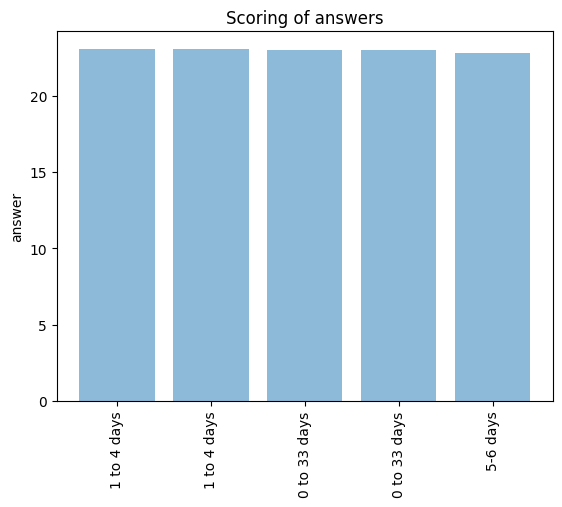

In [219]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
s_pred_df_1=df_temp.sort_values('final_score',ascending=False)[0:5]
objects = s_pred_df_1['answer']
y_pos = np.arange(len(objects))
performance = s_pred_df_1['final_score']

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation='vertical')
#plt.xticks()
plt.ylabel('answer')
plt.title('Scoring of answers')

plt.show() 

In [0]:
df_temp2=pd.read_csv('task1_q_0.csv', header=None,names=["answer", "probability","start","end","qas_id","title","paragraph","retriver_score","final_score"])

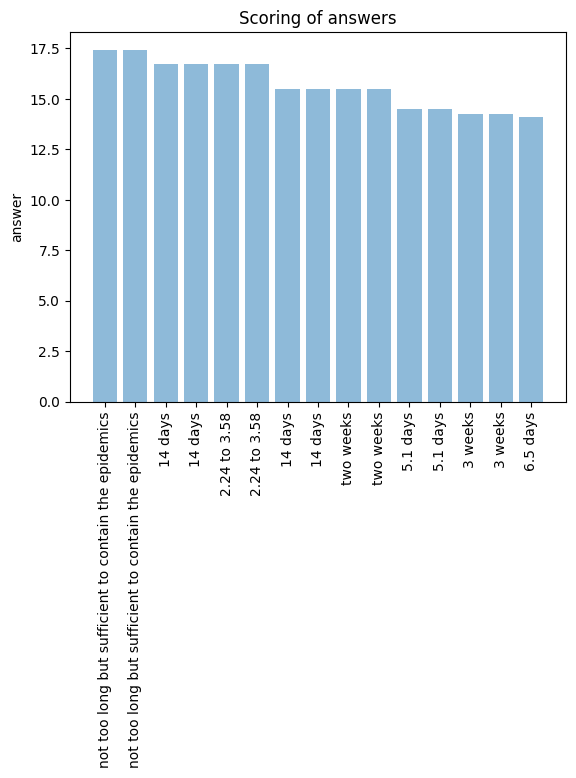

In [221]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
s_pred_df_1=df_temp2.sort_values('final_score',ascending=False)[0:15]
objects = s_pred_df_1['answer']
y_pos = np.arange(len(objects))
performance = s_pred_df_1['final_score']

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation='vertical')
#plt.xticks()
plt.ylabel('answer')
plt.title('Scoring of answers')

plt.show() 

In [0]:
from IPython.core.display import display, HTML 

In [0]:
def print_queries(query,taskNumber,path=None,k=3):
    for j in range(len(query)):
        if(path):
            df=pd.read_csv(path+'task'+str(taskNumber)+'/'+'task'+str(taskNumber)+'_q_'+str(j)+'.csv',header=None)
        else:
            df=pd.read_csv('task'+str(taskNumber)+'_q_'+str(j)+'.csv',header=None)
            df = df.sort_values(df.columns[8],ascending=False)
            df.reset_index(drop = True, inplace = True)
        display(HTML(f'<h2 class="question" > QUERY: {j+1}: \n {query[j]} \n</h2>'))
        for i in range(0,k):
            display(HTML(f'<h3 class="answer">ANSWER: {i+1}: \n {df[0][i]} </h3>'))
            display(HTML(f'<h4 >TITLE: {i+1}: \n {df[5][i]} </h4> '))
            display(HTML(f'<h4 >DESCRIBED IN PAPER: \n</h4>  {df[6][i]} '))

In [103]:
%%HTML
<style type="text/css">
h2.question {
     background-color: steelblue; 
     color: white; 
     padding: 8px; 
     padding-right: 30px; 
     font-size: 24px; 
     max-width: 1500px; 
     margin-top: 10px;
     margin-bottom:4px;
 }
h3.answer {
     background-color: skyblue; 
     color: black; 
     padding: 8px; 
     padding-right: 30px; 
     font-size: 20px; 
     max-width: 1500px; 
     margin-top: 4px;
     margin-bottom:4px;
 }
</style>

In [226]:
print_queries(queries,1)